In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, 3, 1, 1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(3, 6, 3, 1, 1)
        self.pool2 = nn.MaxPool2d(2)
        
        self.conv_trans1 = nn.ConvTranspose2d(6, 3, 4, 2, 1)
        self.conv_trans2 = nn.ConvTranspose2d(3, 1, 4, 2, 1)
        
    def forward(self, x):
        x = F.relu(self.pool1(self.conv1(x)))
        x = F.relu(self.pool2(self.conv2(x)))        
        x = F.relu(self.conv_trans1(x))
        x = self.conv_trans2(x)
        return x



In [2]:
import torchvision

n_epochs = 3
batch_size_train = 8
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

In [3]:
model = MyModel()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 1
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        
    print('Epoch {}, Batch idx {}, loss {}'.format(
        epoch, batch_idx, loss.item()))



Epoch 0, Batch idx 7499, loss -34129764.0


In [4]:
print(model)

MyModel(
  (conv1): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_trans1): ConvTranspose2d(6, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv_trans2): ConvTranspose2d(3, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)


In [5]:
def normalize_output(img):
    img = img - img.min()
    img = img / img.max()
    return img

'''
# Plot some images
idx = torch.randint(0, output.size(0), ())
pred = normalize_output(output[idx, 0])
img = data[idx, 0]

fig, axarr = plt.subplots(1, 2)
axarr[0].imshow(img.detach().numpy())
axarr[1].imshow(pred.detach().numpy())
'''
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model,input, output):
        activation[name] = output.detach()
    return hook

model.conv1.register_forward_hook(get_activation('conv1'))
model.conv2.register_forward_hook(get_activation('conv2'))
model.conv_trans1.register_forward_hook(get_activation('conv_trans1'))
model.pool1.register_forward_hook(get_activation('pool1'))

In [6]:
dataset = torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

'''
data, _ = dataset[1]
data.unsqueeze_(0)
output = model(data)

act = activation['conv1'].squeeze()
fig, axarr = plt.subplots(act.size(0))
for idx in range(act.size(0)):
    axarr[idx].imshow(act[idx])
'''

"\ndata, _ = dataset[1]\ndata.unsqueeze_(0)\noutput = model(data)\n\nact = activation['conv1'].squeeze()\nfig, axarr = plt.subplots(act.size(0))\nfor idx in range(act.size(0)):\n    axarr[idx].imshow(act[idx])\n"

In [7]:
import numpy as np
m = nn.ReLU()
def convert_to_ones(inp):
    #relu_inp = m(inp)
    inp[inp <= 100] = 0
    inp[inp > 100] = 1
    return inp

0.5471938775510204
0.3010204081632653
0.061224489795918366
0.4897959183673469


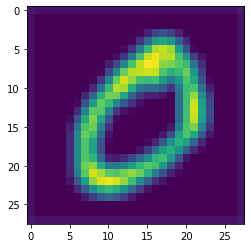

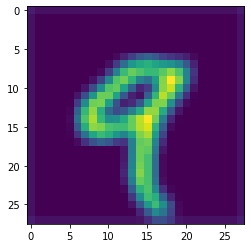

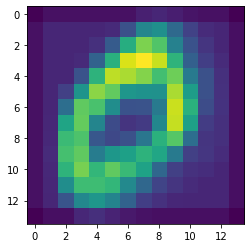

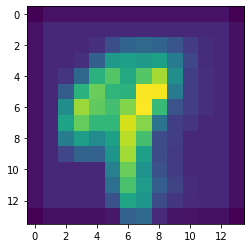

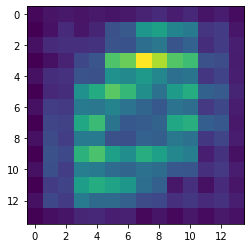

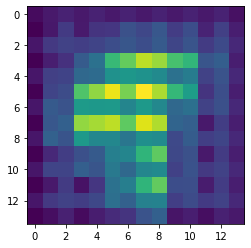

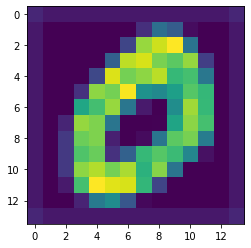

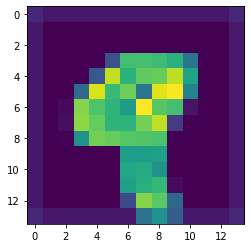

In [37]:
def diff(name, indx1, indx2):
    def convert(index, name):
        data, _ = dataset[index]
        data.unsqueeze_(0)
        output = model(data)
        act = activation[name].squeeze()
        fig, axarr = plt.subplots(1)
        tensor = act[0]
        for idx in range(1, act.size(0)):
            tensor += act[idx]
        #tensor = convert_to_ones(tensor)
        plt.imshow(tensor)
        return tensor
    
    tensor1 = convert(indx1, name)
    tensor2 = convert(indx2, name)
    intersection = torch.sum(tensor1 == tensor2).item() / (tensor1.shape[0] * tensor1.shape[1])
    return intersection
print(diff('conv1', 1, 4))
print(diff('conv2', 1, 4))
print(diff('conv_trans1', 1, 4))
print(diff('pool1', 1, 4))

# Using a classifier network

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #print(x.shape)
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
    
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), 'results/model.pth')
            torch.save(optimizer.state_dict(), 'results/optimizer.pth')
    

def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            test_loss /= len(test_loader.dataset)
            test_losses.append(test_loss)
            print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))



In [16]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 0.2300, Accuracy: 87/10000 (1%)


Test set: Avg. loss: 0.2297, Accuracy: 179/10000 (2%)


Test set: Avg. loss: 0.2302, Accuracy: 258/10000 (3%)


Test set: Avg. loss: 0.2298, Accuracy: 348/10000 (3%)


Test set: Avg. loss: 0.2300, Accuracy: 440/10000 (4%)


Test set: Avg. loss: 0.2304, Accuracy: 524/10000 (5%)


Test set: Avg. loss: 0.2302, Accuracy: 619/10000 (6%)


Test set: Avg. loss: 0.2301, Accuracy: 701/10000 (7%)


Test set: Avg. loss: 0.2305, Accuracy: 800/10000 (8%)


Test set: Avg. loss: 0.2295, Accuracy: 889/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.344846
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.272163
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.258888
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.315608
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.277501
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.201874
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.242983
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.156254
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.094819
Train Epoch: 

Train Epoch: 2 [31360/60000 (52%)]	Loss: 0.245540
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.275096
Train Epoch: 2 [32640/60000 (54%)]	Loss: 0.349338
Train Epoch: 2 [33280/60000 (55%)]	Loss: 0.503475
Train Epoch: 2 [33920/60000 (57%)]	Loss: 0.433165
Train Epoch: 2 [34560/60000 (58%)]	Loss: 0.301510
Train Epoch: 2 [35200/60000 (59%)]	Loss: 0.470247
Train Epoch: 2 [35840/60000 (60%)]	Loss: 0.194165
Train Epoch: 2 [36480/60000 (61%)]	Loss: 0.236121
Train Epoch: 2 [37120/60000 (62%)]	Loss: 0.261284
Train Epoch: 2 [37760/60000 (63%)]	Loss: 0.245381
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.359723
Train Epoch: 2 [39040/60000 (65%)]	Loss: 0.438134
Train Epoch: 2 [39680/60000 (66%)]	Loss: 0.360230
Train Epoch: 2 [40320/60000 (67%)]	Loss: 0.328114
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.420417
Train Epoch: 2 [41600/60000 (69%)]	Loss: 0.395165
Train Epoch: 2 [42240/60000 (70%)]	Loss: 0.224896
Train Epoch: 2 [42880/60000 (71%)]	Loss: 0.429919
Train Epoch: 2 [43520/60000 (72%)]	Loss: 0.352085


In [46]:
def convert_to_classid(inp, class_id):
    inp[inp <= 100] = 0
    inp[inp > 100] = class_id * 10
    return inp

def diff2(name, indx1, indx2):
    def convert(index, name):
        data, _ = dataset[index]
        data.unsqueeze_(0)
        output = network(data)
        act = activation[name].squeeze()
        fig, axarr = plt.subplots(1)
        tensor = act[0]
        #for idx in range(1, act.size(0)):
        #    tensor += act[idx]
        #tensor = convert_to_ones(tensor)
        plt.imshow(tensor)
        return tensor
    
    tensor1 = convert(indx1, name)
    tensor2 = convert(indx2, name)
    intersection = torch.sum(tensor1 == tensor2).item() / (tensor1.shape[0] * tensor1.shape[1])
    return intersection

In [47]:
def normalize_output(img):
    img = img - img.min()
    img = img / img.max()
    return img

# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(network,input, output):
        activation[name] = output.detach()
    return hook

network.conv1.register_forward_hook(get_activation('conv1'))
network.conv2.register_forward_hook(get_activation('conv2'))
network.conv2_drop.register_forward_hook(get_activation('conv2_drop'))
network.fc1.register_forward_hook(get_activation('fc1'))
network.fc2.register_forward_hook(get_activation('fc2'))

torch.Size([1, 10, 24, 24])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


0.23958333333333334
0.0
0.0


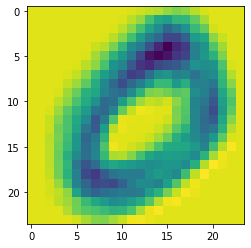

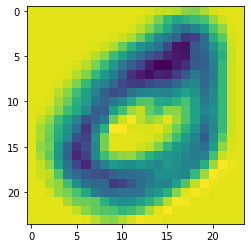

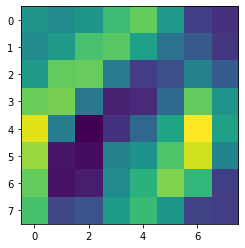

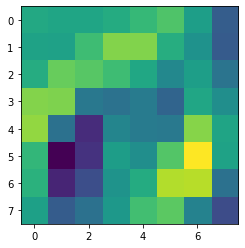

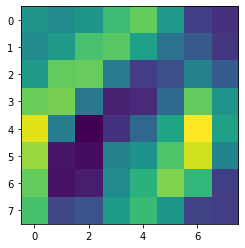

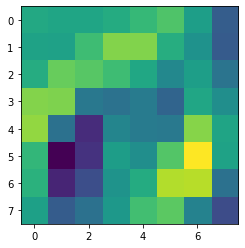

In [50]:
ind1 = 1
ind2 = 21
print(diff2('conv1', ind1, ind2))
print(diff2('conv2', ind1, ind2))
print(diff2('conv2_drop', ind1, ind2))
#print(diff2('fc1', 1, 4))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


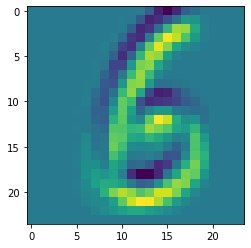

In [36]:
data, _ = dataset[18]
data.unsqueeze_(0)
output = network(data)
act = activation['conv1'].squeeze()
fig, axarr = plt.subplots(1)
test = act[0]
for idx in range(1, act.size(0)):
    test += act[idx]
#test = convert_to_classid(test,output.argmax().item())
plt.imshow(test)

In [31]:
output.argmax().item()

6

In [105]:
activation.keys()

dict_keys(['conv1', 'pool1', 'conv2', 'conv_trans1'])

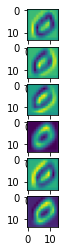

In [7]:
act = activation['conv2'].squeeze()
fig, axarr = plt.subplots(act.size(0))
for idx in range(act.size(0)):
    axarr[idx].imshow(act[idx])

In [ ]:
model.conv_trans1.register_forward_hook(get_activation('conv_trans1'))

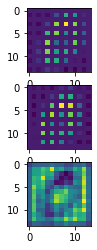

In [8]:
act = activation['conv_trans1'].squeeze()
fig, axarr = plt.subplots(act.size(0))
for idx in range(act.size(0)):
    axarr[idx].imshow(act[idx])

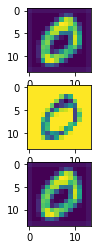

In [9]:
act = activation['pool1'].squeeze()
fig, axarr = plt.subplots(act.size(0))
for idx in range(act.size(0)):
    axarr[idx].imshow(act[idx])

In [ ]:
activation.keys()